In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import scipy
from scipy import stats 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import *
import matplotlib.colors as colors
import openpyxl
from netCDF4 import Dataset
import h5netcdf

In [2]:
#Gra Mera 5km
sourceData='/bettik/PROJECTS/pr-regional-climate/santolam/MARout/GRa/spin2/work/monthly/'
variable='TT' ##RF;SF;SHSN3;TT
fileNameM='TTZ_mon_MARv3.14_ER5_spin2_GRa_2000-2023.nc' 
dsM= xr.open_dataset(sourceData+fileNameM)['TTZ'][:,1,:,:]

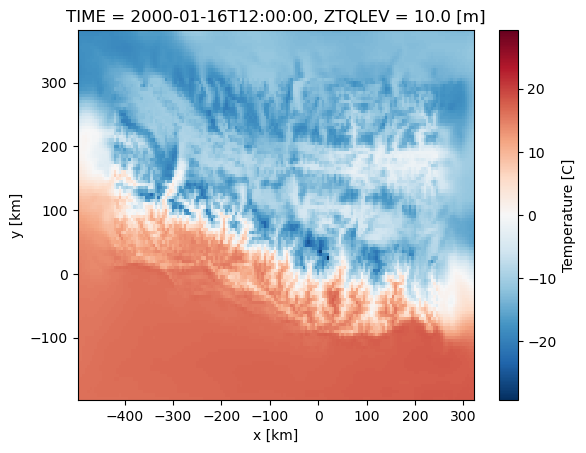

In [3]:
dsM[0,:,:].plot()

In [4]:
## Model MAR
sourceDataGrid='/home/amoryc/'
#fileName_grF='NST.2000.01.01.00.GRa_Fedchenko.nc'
fileName_grM='NST.2000.01.01.00.GRa_Mera.nc_ICEmask'
ds_grM= xr.open_dataset(sourceDataGrid+fileName_grM)

In [5]:
###
#AWS-Mera La: Since November 2013 (AWS inserted on firm rocks – off-glacier)
#Location in WGS84, Lat: 27.735°N; Long: 86.900°E; Elevation: 5352.008 m 
#or UTM Zone 45; Easting: 490137.007 m; Northing: 3067850.613 m on 22/11/2020
###
lon_Changri=86.77948450
lat_Changri=27.98336311
elev_Changri=5360
##Find the pixel of MAR corresponding to station
target_lon = lon_Changri
target_lat = lat_Changri
lon=ds_grM.LON
lat=ds_grM.LAT

In [6]:
#Step 2: Find the nearest grid point to target_lon,target_lat
# Compute distance to each grid point
dist = np.sqrt((lon - target_lon)**2 + (lat - target_lat)**2)
print(dist)
j, i = np.unravel_index(dist.argmin(), dist.shape)

<xarray.DataArray (y: 116, x: 164)> Size: 76kB
array([[5.2705283, 5.2242417, 5.178023 , ..., 3.8274531, 3.8701384,
        3.912993 ],
       [5.2544045, 5.2079577, 5.161576 , ..., 3.8043795, 3.847324 ,
        3.890469 ],
       [5.238618 , 5.1919956, 5.1454506, ..., 3.7816935, 3.8249161,
        3.8683245],
       ...,
       [5.857553 , 5.813447 , 5.7694645, ..., 4.5143867, 4.5527673,
        4.5913987],
       [5.882204 , 5.8382554, 5.7944493, ..., 4.545453 , 4.5836015,
        4.6219974],
       [5.907094 , 5.86332  , 5.8196645, ..., 4.576767 , 4.6146655,
        4.6528387]], shape=(116, 164), dtype=float32)
Coordinates:
  * x        (x) float32 656B -495.0 -490.0 -485.0 -480.0 ... 310.0 315.0 320.0
  * y        (y) float32 464B -195.0 -190.0 -185.0 -180.0 ... 370.0 375.0 380.0


In [7]:
print(j,i)

45 97


In [8]:
#Step 3: Extract data at that location
# For a single time step
#value = dsM['SH'].isel(y=j, x=i)
## If there's a time dimension
dsM_sta=dsM[0:, i, j+1]





dsM_sta_new2= dsM_sta.rename({'TIME': 'time'})
#units=dsM.units
dsM_sta_new= dsM_sta_new2.where(dsM_sta_new2.values <= 70)
#dsM_sta_new.values


In [9]:
#Evaluer la différence de hauteur entre la station et le niveau 1 de la grille MAR considérée
SH_sta=elev_Changri
value = ds_grM['SH'].isel(y=j+1, x=i)
diff=SH_sta-value.values
diff,SH_sta,value.values

(np.float32(-81.24414), 5360, array(5441.244, dtype=float32))

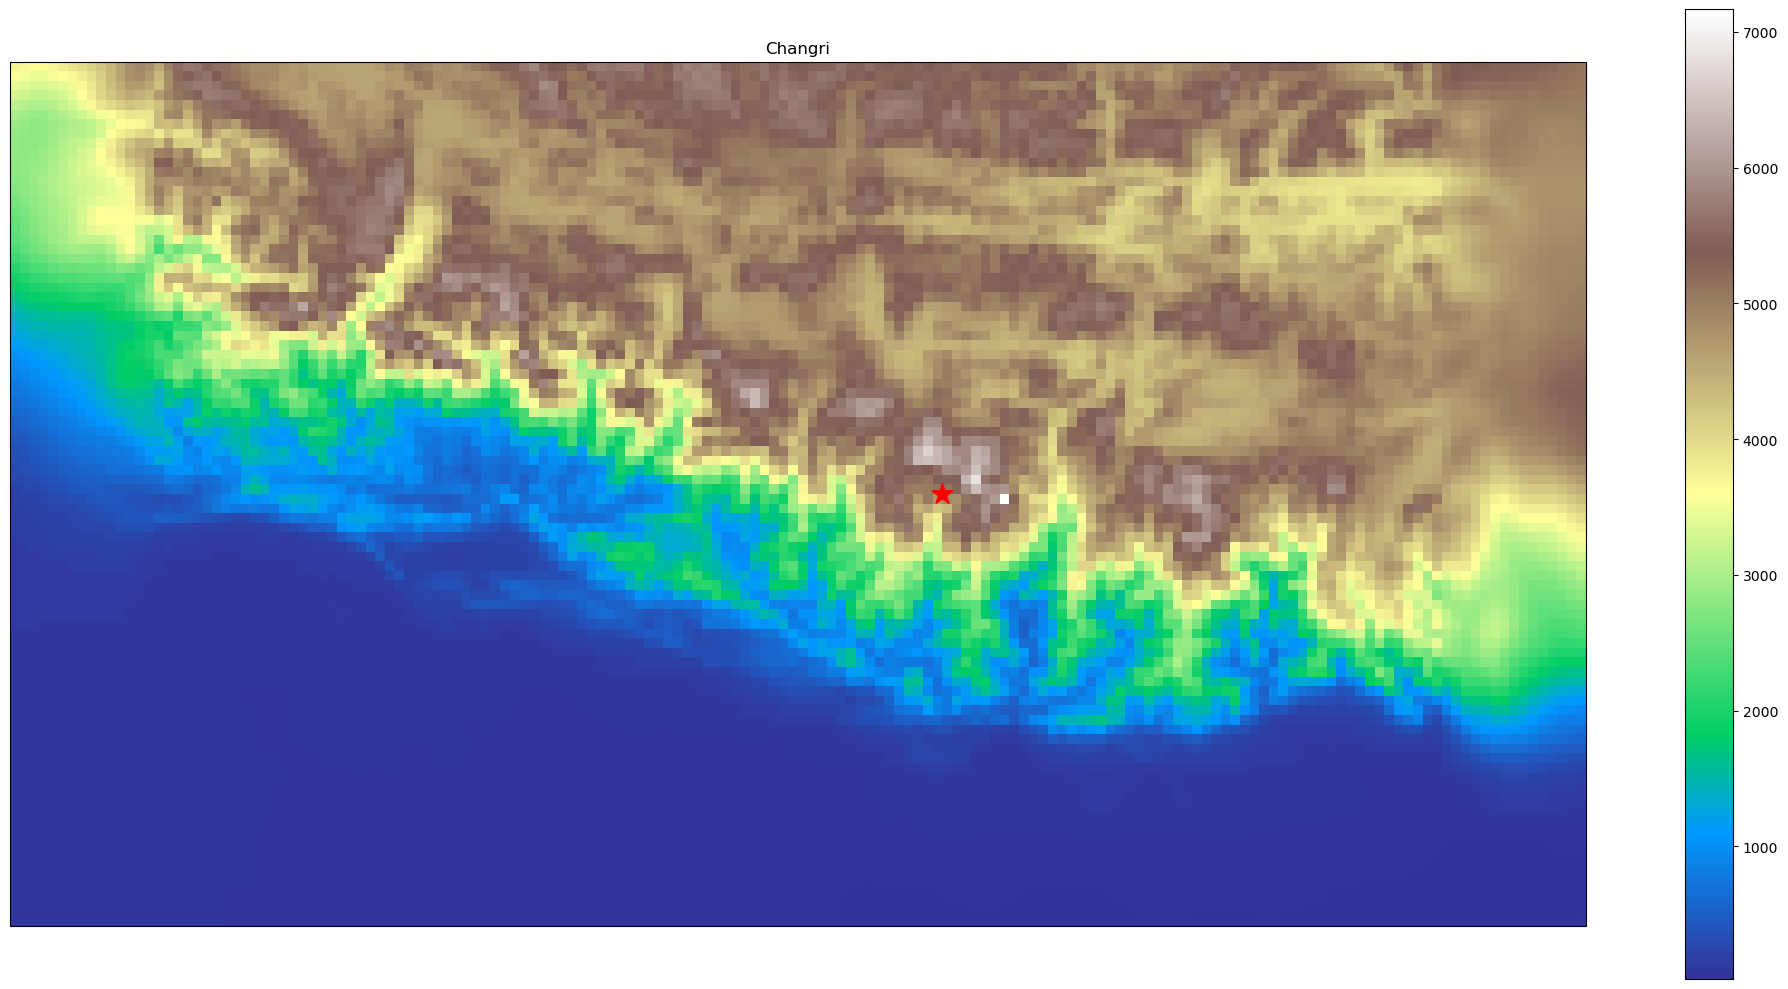

In [10]:
##
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(20,10))
cmap='terrain'

m1=axs.pcolormesh(ds_grM.SH,cmap=cmap)
axs.scatter(i,j,s=250,marker='*',color='red',linewidths=1.,edgecolors='red') #vérifier si coordonées sont dans le bon référenciel.

axs.set_title('Changri')
fig.colorbar(m1,orientation='vertical')

#ax1.set_title('contourf with levels')
fig.tight_layout()

plt.show()

In [11]:
####
## Opening station data
####

In [12]:
sourceData3='/bettik/PROJECTS/pr-regional-climate/santolam/glacioclim/donnees_meteo/'
fileName3='Changri5360final2010_12bonscoeff.xlsx'
xl_file3 = pd.ExcelFile(sourceData3+fileName3)

In [13]:
dfs3 = {sheet_name: xl_file3.parse(sheet_name) 
          for sheet_name in xl_file3.sheet_names}
Data3=dfs3['Changri2010_12']

NameVars3=['Time','SWin','SWout','LWin','LWout','Tair','RH','Height/surf','U','Dir','T1-2,5cm','T2-5cm','T3-7,5cm','T4-10cm']
UnitVars3=['data/hour','W/m2','W/m2','W/m2','W/m2','(°C)','%','m/s','degres','(°C)','(°C)','(°C)','(°C)']

##Define new DataFrame and changing name of columns
dfile3 = pd.DataFrame(data=Data3.loc[14:])
df3=pd.DataFrame(dfile3.values, columns=NameVars3)

### Opening one column + converting into an array
Tair_ar3=[float(i) for i in df3.Tair.values]


In [14]:
sourceData2='/bettik/PROJECTS/pr-regional-climate/santolam/glacioclim/donnees_meteo/'
fileName2='Changri5360final2012_14bonscoeff.xlsx'
xl_file2 = pd.ExcelFile(sourceData2+fileName2)
print(xl_file2)

In [15]:
dfs2 = {sheet_name: xl_file2.parse(sheet_name) 
          for sheet_name in xl_file2.sheet_names}
Data2=dfs2['Changri2012_14']

NameVars2=['Time','SWin','SWout','LWin','LWout','Tair','RH','Height/surf','Uhight','Dir','T4','T3','T2','T1','ulow','dir']
UnitVars2=['data/hour','W/m2','W/m2','W/m2','W/m2','(°C)','%','m/s','degres','W/m2','W/m2','(°C)','(°C)','(°C)','m/s','degrees']

##Define new DataFrame and changing name of columns
dfile2 = pd.DataFrame(data=Data2.loc[14:])
df2=pd.DataFrame(dfile2.values, columns=NameVars2)

### Opening one column + converting into an array
Tair_ar2=[float(i) for i in df2.Tair.values]


In [16]:
sourceData1='/bettik/PROJECTS/pr-regional-climate/santolam/glacioclim/donnees_meteo/'
fileName1='Changri5360final2014_24.xlsx'
xl_file1 = pd.ExcelFile(sourceData1+fileName1)
print(xl_file1)

In [17]:
dfs1 = {sheet_name: xl_file1.parse(sheet_name) 
          for sheet_name in xl_file1.sheet_names}
Data1=dfs1['Changri_5360_2014_23']

NameVars1=['Time','SWin','SWout','LWin','LWout','Tair','RH','Height/surf','Uhight','Dir','Flux-21cm','T1-1cm','T2-16cm','T3-21cm','ulow','dir']
UnitVars1=['data/hour','W/m2','W/m2','W/m2','W/m2','(°C)','%','m/s','degres','W/m2','W/m2','(°C)','(°C)','(°C)','m/s','degrees']

##Define new DataFrame and changing name of columns
dfile1 = pd.DataFrame(data=Data1.loc[14:])
df1=pd.DataFrame(dfile1.values, columns=NameVars1)

### Opening one column + converting into an array
Tair_ar1=[float(i) for i in df1.Tair.values]


In [18]:
##In original time data from DataFrame, frequency is not defined so I cannot use the usual fonction (xr,pd)
##Need to redefine a time array + build a xarray of variable V=V(time)
def NewTime(df, NameVar, values, freq):
	time = pd.to_datetime(df['Time'].values)
	ds = xr.Dataset({NameVar: ("time", np.asarray(values))}, coords={"time": time})
	return ds
    

In [19]:
#Définition Variables

T1=NewTime(df1,'Tair',Tair_ar1,'30min')
T2=NewTime(df2,'Tair',Tair_ar2,'30min')
T3=NewTime(df3,'Tair',Tair_ar3,'30min')


T = xr.concat([T3, T2,T1], dim='time')


In [20]:
daily_meanT=T.resample(time='D').mean()                          #Utilisation de la librairie xarray maintenant possible car les données ont une forme bien définie
monthly_meanT=daily_meanT.resample(time='ME').mean()             # chaque variable ici défini est un xarray.Dataset
yearly_meanT=monthly_meanT.resample(time='YE').mean()
#daily_meanTM

In [21]:
#Définition des Saisons, et création d'une fonction qui définit les saisons en fonction des périodes des moussons:
seasons = {
	'MAM': [3, 4, 5],  	
	'JJAS': [6, 7, 8, 9],  
	'ON': [10, 11],    	
	'DJF': [12, 1, 2]  	
}
def seasonsdata(ds, season_name):  #monthly_meanTM.sel(time=monthly_meanTM['time'].dt.month.isin(seasons['MAM'])). Sélectionne dans le dataset les mois correspondants aux saisons définies au dessus

	x = seasons[season_name]
	return ds.sel(time=ds['time'].dt.month.isin(x))


In [22]:
# Get the time coordinates CORRIGER DIFF ENTRE MAR ET STATION
time1 = monthly_meanT['time']# début 2013-11-15 fin 2024-11-28
time2 = dsM_sta_new['time'] # début 2003-01-01T12: fin 2013-12-31T12
start=time1[0] 
end=time2[-1]

In [23]:
ts_sta=monthly_meanT.sel(time=slice(start,end))
ts_MAR=dsM_sta_new.sel(time=slice(start,end))

#Annual cycle:
Tsta_cycle=ts_sta.groupby('time.dayofyear').mean()

TMAR_daily_cycle=ts_MAR.groupby('time.dayofyear').mean()
plt.plot(Tsta_daily_cycle.dayofyear,Tsta_daily_cycle.Tair,     
    color='darkblue',linestyle='-',label='Tair')
plt.title('Mean annual cycle of daily surface Temperatures')
plt.xlabel('Day of year')
plt.ylabel('Température (°C)')
#Annual cycle:
plt.plot(TMAR_daily_cycle.dayofyear,TMAR_daily_cycle.values,    
    color='red',linestyle='-',label='Tair MAR')
plt.legend()
plt.grid(True)




In [24]:
Tsta_monthly_cycle=ts_sta.groupby('time.month').mean()
TMAR_monthly_cycle=ts_MAR.groupby('time.month').mean()

In [25]:
Tsta_premon = seasonsdata(ts_sta, 'MAM').groupby('time.month').mean()

Tsta_mon = seasonsdata(ts_sta, 'JJAS').groupby('time.month').mean()

Tsta_postmon =  seasonsdata(ts_sta, 'ON').groupby('time.month').mean()

Tsta_hiver  = seasonsdata(ts_sta, 'DJF').groupby('time.month').mean()


In [26]:
#Time series annual data sta
Timeseries_Tsta_premon = seasonsdata(ts_sta, 'MAM').resample(time='YE').mean() # T moyen de chaque saison 
Timeseries_Tsta_mon = seasonsdata(ts_sta, 'JJAS').resample(time='YE').mean()
Timeseries_Tsta_postmon =  seasonsdata(ts_sta, 'ON').resample(time='YE').mean()
Timeseries_Tsta_hiver  = seasonsdata(ts_sta, 'DJF').resample(time='YE').mean()

In [27]:
#dsM_sta_new


TMAR_premon = seasonsdata(ts_MAR, 'MAM').groupby('time.month').mean()

TMAR_mon = seasonsdata(ts_MAR, 'JJAS').groupby('time.month').mean()

TMAR_postmon =  seasonsdata(ts_MAR, 'ON').groupby('time.month').mean()

TMAR_hiver  = seasonsdata(ts_MAR, 'DJF').groupby('time.month').mean()



#T MAR Corrected for [elevation / Hight ? ]
#Evaluer la différence de hauteur entre la station et le niveau 1 de la grille MAR considérée
SH_sta=elev_Changri
value = ds_grM['SH'].isel(y=j+1, x=i)
diff=SH_sta-value.values
print(value.values,SH_sta,diff)

TMAR_monthly_cycle_corrected = TMAR_monthly_cycle+(+5.2*0.081)


5441.244 5360 -81.24414


In [28]:
#Time series annual data MAR 
Timeseries_TMAR_premon = seasonsdata(ts_MAR, 'MAM').resample(time='YE').mean() # T moyen de chaque saison 
Timeseries_TMAR_mon = seasonsdata(ts_MAR, 'JJAS').resample(time='YE').mean()
Timeseries_TMAR_postmon =  seasonsdata(ts_MAR, 'ON').resample(time='YE').mean()
Timeseries_TMAR_hiver  = seasonsdata(ts_MAR, 'DJF').resample(time='YE').mean()


-81.24414


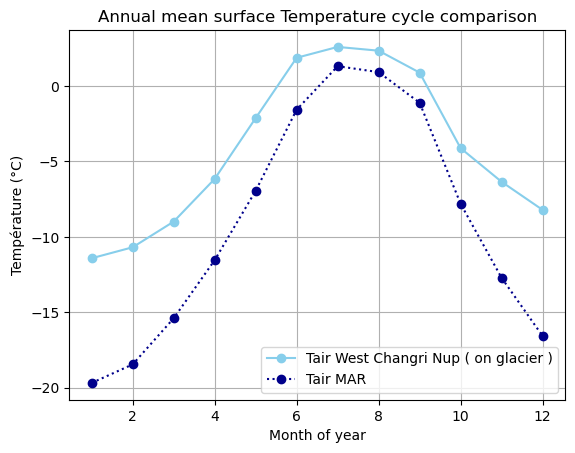

In [46]:
#Monthly cycle

plt.plot(Tsta_monthly_cycle.month,Tsta_monthly_cycle.Tair,
    color='skyblue',linestyle='-',label='Tair West Changri Nup ( on glacier )',marker= 'o')

plt.plot(TMAR_monthly_cycle.month,TMAR_monthly_cycle.values,
    color='darkblue',linestyle=':',label='Tair MAR',marker= 'o')
#plt.plot(TMAR_monthly_cycle_corrected.month,TMAR_monthly_cycle_corrected.values,
 #   color='orange',linestyle='-',label='Tair MAR corrected')
plt.legend()
plt.title('Annual mean surface Temperature cycle comparison')
plt.xlabel('Month of year')
plt.ylabel('Température (°C)')

plt.grid(True)
print(diff)

#Details mois saisons, 

fig, ((ax1,ax2) , (ax3,ax4)) = plt.subplots(2,2, figsize=(20,16))
ax1.plot(Tsta_premon.month, Tsta_premon['Tair'].values, linestyle=':', marker= 'o', label='Tair Station MeraLA')
ax1.plot(TMAR_premon.month, TMAR_premon.values, linestyle=':', marker= 'o', label='Tair MAR')
ax1.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax1.set_title('MAM')
ax1.set_xlabel('Month')
ax1.set_ylabel('Température (°C)')
ax1.grid()

ax2.plot(Tsta_mon.month, Tsta_mon['Tair'].values, linestyle=':', marker= 'o', label='Tair Station MeraLA')
ax2.plot(TMAR_mon.month, TMAR_mon.values, linestyle=':', marker= 'o', label='Tair')
ax2.set_title('JJAS')
ax2.set_xlabel('Month')
ax2.set_ylabel('Température (°C)')
ax2.grid()

ax3.plot(Tsta_postmon.month, Tsta_postmon['Tair'].values, linestyle=':', marker= 'o', label='Tair Station MeraLA')
ax3.plot(TMAR_postmon.month, TMAR_postmon.values, linestyle=':', marker= 'o', label='Tair MAR')
ax3.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax3.set_title('ON')
ax3.set_xlabel('Month')
ax3.set_ylabel('Température (°C)')
ax3.grid()

ax4.plot(Tsta_hiver.month, Tsta_hiver['Tair'].values, linestyle=':', marker= 'o', label='Tair Station MeraLA')
ax4.plot(TMAR_hiver.month, TMAR_hiver.values, linestyle=':', marker= 'o', label='Tair MAR')
ax4.legend(bbox_to_anchor=(1, 0, 0.5, 0.5)) 
ax4.set_title('DJF')
ax4.set_xlabel('Month')
ax4.set_ylabel('Température (°C)')
ax4.grid()


fig.suptitle('Seasonsal Comparaisons between MAR model and MeraLa stations data')

-81.24414


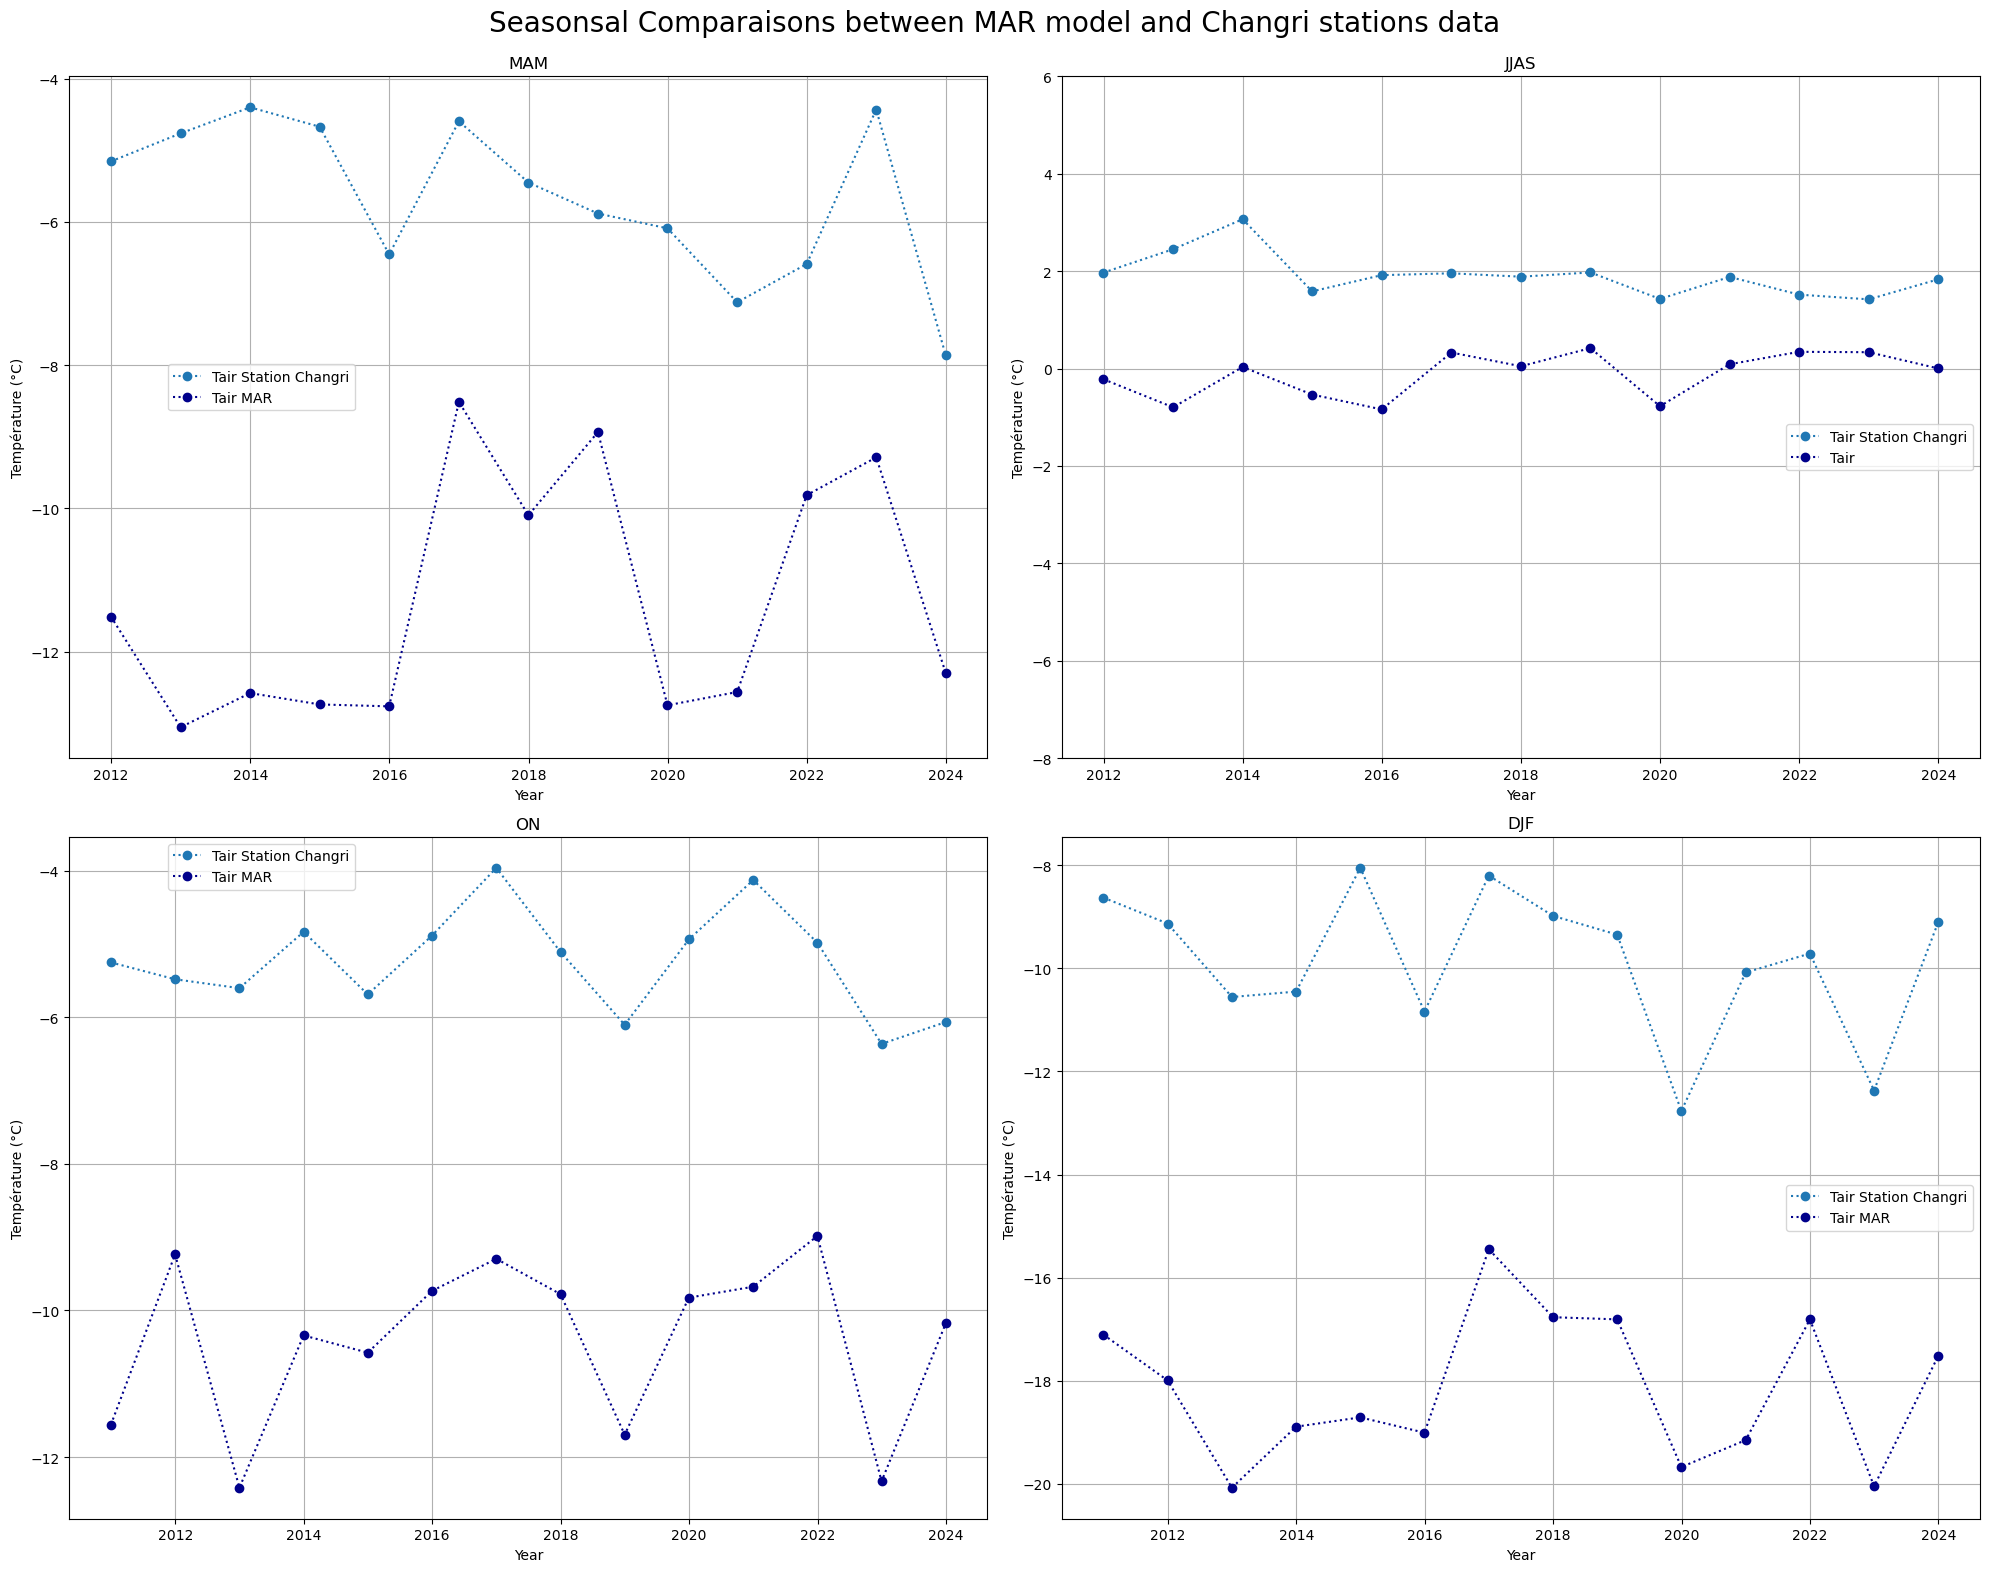

In [43]:
#Ajout incertitudes, 

fig, ((ax1,ax2) , (ax3,ax4)) = plt.subplots(2,2, figsize=(20,16))
ax1.plot(Timeseries_Tsta_premon.time, Timeseries_Tsta_premon['Tair'].values, linestyle=':', marker= 'o', label='Tair Station Changri')
ax1.plot(Timeseries_TMAR_premon.time, Timeseries_TMAR_premon.values, linestyle=':', marker= 'o',color='darkblue', label='Tair MAR')

ax1.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax1.set_title('MAM')
ax1.set_xlabel('Year')
ax1.set_ylabel('Température (°C)')
ax1.grid()

ax2.plot(Timeseries_Tsta_mon.time, Timeseries_Tsta_mon['Tair'].values, linestyle=':', marker= 'o', label='Tair Station Changri')
ax2.plot(Timeseries_TMAR_mon.time, Timeseries_TMAR_mon.values, linestyle=':',color='darkblue', marker= 'o', label='Tair')

ax2.legend(bbox_to_anchor=(0.5, 0, 0.5, 0.5)) 
ax2.set_title('JJAS')
ax2.set_xlabel('Year')
ax2.set_ylabel('Température (°C)')
ax2.set_yticks(np.arange(-8, 8, 2))  
ax2.grid()

ax3.plot(Timeseries_Tsta_postmon.time, Timeseries_Tsta_postmon['Tair'].values, linestyle=':', marker= 'o', label='Tair Station Changri')
ax3.plot(Timeseries_TMAR_postmon.time, Timeseries_TMAR_postmon.values, linestyle=':',color='darkblue', marker= 'o', label='Tair MAR')


ax3.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax3.set_title('ON')
ax3.set_xlabel('Year')
ax3.set_ylabel('Température (°C)')
ax3.grid()

ax4.plot(Timeseries_Tsta_hiver.time, Timeseries_Tsta_hiver['Tair'].values, linestyle=':', marker= 'o', label='Tair Station Changri')
ax4.plot(Timeseries_TMAR_hiver.time, Timeseries_TMAR_hiver.values, linestyle=':',color='darkblue', marker= 'o', label='Tair MAR')

ax4.legend(bbox_to_anchor=(0.5, 0, 0.5, 0.5)) 
ax4.set_title('DJF')
ax4.set_xlabel('Year')
ax4.set_ylabel('Température (°C)')
ax4.grid()


plt.tight_layout(rect=[0, 0, 1, 0.96])  # Maria script theft : leave space for the suptitle
fig.suptitle('Seasonsal Comparaisons between MAR model and Changri stations data',fontsize=20)
print(diff)

In [33]:
xr.corr(Timeseries_TMAR_premon,Timeseries_Tsta_premon.Tair,dim=None, weights=None)

<xarray.DataArray ()> Size: 8B
array(0.21498451)
Coordinates:
    X        float32 4B -265.0
    Y        float32 4B 290.0
    ZTQLEV   float32 4B 10.0

In [34]:
xr.corr(Timeseries_TMAR_mon,Timeseries_Tsta_mon.Tair,dim=None, weights=None)

<xarray.DataArray ()> Size: 8B
array(-0.04876145)
Coordinates:
    X        float32 4B -265.0
    Y        float32 4B 290.0
    ZTQLEV   float32 4B 10.0

In [35]:
xr.corr(Timeseries_TMAR_postmon,Timeseries_Tsta_postmon.Tair,dim=None, weights=None)

<xarray.DataArray ()> Size: 8B
array(0.64210394)
Coordinates:
    X        float32 4B -265.0
    Y        float32 4B 290.0
    ZTQLEV   float32 4B 10.0

In [36]:
xr.corr(Timeseries_TMAR_hiver,Timeseries_Tsta_hiver.Tair,dim=None, weights=None)

<xarray.DataArray ()> Size: 8B
array(0.73730722)
Coordinates:
    X        float32 4B -265.0
    Y        float32 4B 290.0
    ZTQLEV   float32 4B 10.0

In [37]:
xr.corr(TMAR_monthly_cycle,Tsta_monthly_cycle.Tair,dim=None, weights=None)

<xarray.DataArray ()> Size: 8B
array(0.99368012)
Coordinates:
    X        float32 4B -265.0
    Y        float32 4B 290.0
    ZTQLEV   float32 4B 10.0

In [38]:
print(xr.corr(Timeseries_TMAR_premon,Timeseries_Tsta_premon.Tair,dim=None, weights=None),
xr.corr(Timeseries_TMAR_mon,Timeseries_Tsta_mon.Tair,dim=None, weights=None),
xr.corr(Timeseries_TMAR_hiver,Timeseries_Tsta_hiver.Tair,dim=None, weights=None),
xr.corr(TMAR_monthly_cycle,Tsta_monthly_cycle.Tair,dim=None, weights=None))

<xarray.DataArray ()> Size: 8B
array(0.21498451)
Coordinates:
    X        float32 4B -265.0
    Y        float32 4B 290.0
    ZTQLEV   float32 4B 10.0 <xarray.DataArray ()> Size: 8B
array(-0.04876145)
Coordinates:
    X        float32 4B -265.0
    Y        float32 4B 290.0
    ZTQLEV   float32 4B 10.0 <xarray.DataArray ()> Size: 8B
array(0.73730722)
Coordinates:
    X        float32 4B -265.0
    Y        float32 4B 290.0
    ZTQLEV   float32 4B 10.0 <xarray.DataArray ()> Size: 8B
array(0.99368012)
Coordinates:
    X        float32 4B -265.0
    Y        float32 4B 290.0
    ZTQLEV   float32 4B 10.0
